In [1]:
!pip install gcm-filters
!pip install xrft==0.3.0

  Using cached gcm_filters-0.1.2-py3-none-any.whl (12 kB)


In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:35245")
client

<Client: 'tcp://127.0.0.1:35245' processes=8 threads=64, memory=235.96 GiB>

In [3]:
client.restart()

<Client: 'tcp://127.0.0.1:37917' processes=7 threads=56, memory=206.47 GiB>

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy.ndimage import rotate
from xgcm.grid import Grid
import gcm_filters
import xrft
import s3fs
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import intake
import os
import gcsfs

gcs = gcsfs.GCSFileSystem(requester_pays=True)

SCRATCH = os.environ['SCRATCH_BUCKET']
SCRATCH

'gcs://meom-ige-scratch/roxyboy'

In [5]:
from validate_catalog import all_params
params_dict, cat = all_params()

hycom50_grid = cat.HYCOM50(region='1_GS', datatype='grid', grid='grid').to_dask()

In [6]:
hycom01ww = cat.HYCOM50(region='1_GS', datatype='int_wvel', season='fma', decode_times=False).to_dask().chunk({'lat':100,'lon':100})
hycom01w = cat.HYCOM50(region='1_GS', datatype='int', season='fma', decode_times=False).to_dask().chunk({'lat':100,'lon':100})
u3 = hycom01w.u3
v3 = hycom01w.v3
hycom01w = hycom01w.drop('u3')
hycom01w = hycom01w.drop('v3')
Ny = len(hycom50_grid.lat)
Nx = len(hycom50_grid.lon)

## Make metadata C-grid again ##

hycom01w['u3'] = xr.DataArray(u3.data, dims=['time','lay','lat','lonG'],
                              coords={'time':hycom01w.time,'lay':hycom01w.lay,
                                      'lat':hycom01w.lat,'lonG':np.arange(-.5,Nx-.5,1)}
                             )
hycom01w['v3'] = xr.DataArray(v3.data, dims=['time','lay','latG','lon'],
                              coords={'time':hycom01w.time,'lay':hycom01w.lay,
                                      'latG':np.arange(-.5,Ny-.5,1),'lon':hycom01w.lon}
                             )
hycom01w.coords['layl'] = np.arange(-.5,31,1)
hycom01w['w3'] = xr.DataArray(hycom01ww.wvel.data, dims=['time','layl','lat','lon'],
                              coords={'time':hycom01w.time,'layl':hycom01w.layl,
                                      'lat':hycom01w.lat,'lon':hycom01w.lon}
                             )
h3l = xr.DataArray(xr.concat([.5*hycom01w.h3.isel(lay=0), .5*(hycom01w.h3.isel(lay=slice(None,-1)).data
                                                              + hycom01w.h3.isel(lay=slice(1,None)))
                             ], 'lay').transpose('time','lay','lat','lon').data,
                   dims=['time','layl','lat','lon'],
                   coords={'time':hycom01w.time,'layl':hycom01w.layl,
                           'lat':hycom01w.lat,'lon':hycom01w.lon}
                  )

Zl = h3l.cumsum('layl',skipna=True)
Zl = Zl.where(Zl>0.).load()
Z = hycom01w.h3.cumsum('lay',skipna=True)
Z = Z.where(Z>0.).load()

hycom01w['Z'] = Z
hycom01w['Zl'] = Zl

coords={'T':{'center':'time'},
        'X':{'center':'lon', 'left':'lonG'}, 
        'Y':{'center':'lat', 'left':'latG'}, 
        'Z':{'center':'lay', 'left':'layl'}
       }

grid = Grid(hycom01w, coords=coords, periodic=[])

hycom01w['Zu'] = grid.interp(Z, 'X', boundary='fill')
hycom01w['Zv'] = grid.interp(Z, 'Y', boundary='fill')

import gsw
xx, yy = np.meshgrid(hycom50_grid.longitude, hycom50_grid.latitude)
dxF = xr.DataArray(gsw.distance(xx, yy), dims=['lat','lon'],
                   coords={'lat':hycom01w.lat,'lon':np.arange(.5,Nx-1,1)}
                  ).interp(lon=hycom01w.lon, method="linear",
                           kwargs={"fill_value": "extrapolate"})
dyF = xr.DataArray(gsw.distance(xx, yy, axis=0), dims=['lat','lon'],
                   coords={'lat':np.arange(.5,Ny-1,1),'lon':hycom01w.lon}
                  ).interp(lat=hycom01w.lat, method="linear",
                           kwargs={"fill_value": "extrapolate"})
dxC = xr.DataArray(xr.DataArray(gsw.distance(xx, yy), dims=['lat','lon'],
                                coords={'lat':hycom01w.lat,'lon':np.arange(.5,Nx-1,1)}
                               ).interp(lon=hycom01w.lonG, method="linear",
                                        kwargs={"fill_value": "extrapolate"}),
                   dims=['lat','lonG'],
                   coords={'lat':hycom01w.lat,'lonG':hycom01w.lonG}
                  )
dyC = xr.DataArray(xr.DataArray(gsw.distance(xx, yy, axis=0), dims=['lat','lon'],
                                coords={'lat':np.arange(.5,Ny-1,1),'lon':hycom01w.lon}
                               ).interp(lat=hycom01w.latG, method="linear",
                                        kwargs={"fill_value": "extrapolate"}),
                   dims=['latG','lon'],
                   coords={'latG':hycom01w.latG,'lon':hycom01w.lon}
                  )
dxG = xr.DataArray(xr.DataArray(gsw.distance(xx, yy), dims=['lat','lon'],
                                coords={'lat':hycom01w.lat,'lon':np.arange(.5,Nx-1,1)}
                               ).interp(lon=hycom01w.lon, method="linear",
                                        kwargs={"fill_value": "extrapolate"}
                                       ).interp(lat=hycom01w.latG, method='linear',
                                                kwargs={"fill_value": "extrapolate"}),
                   dims=['latG','lon'],
                   coords={'latG':hycom01w.latG,'lon':hycom01w.lon}
                  )
dyG = xr.DataArray(xr.DataArray(gsw.distance(xx, yy, axis=0), dims=['lat','lon'],
                                coords={'lat':np.arange(.5,Ny-1,1),'lon':hycom01w.lon}
                               ).interp(lat=hycom01w.lat, method="linear",
                                        kwargs={"fill_value": "extrapolate"}
                                       ).interp(lon=hycom01w.lonG, method='linear',
                                                kwargs={"fill_value": "extrapolate"}),
                   dims=['lat','lonG'],
                   coords={'lat':hycom01w.lat,'lonG':hycom01w.lonG}
                  )

hycom01w['dxF'] = dxF
hycom01w['dyF'] = dyF
hycom01w['dxC'] = dxC
hycom01w['dyC'] = dyC
hycom01w['dxG'] = dxG
hycom01w['dyG'] = dyG
hycom01w

<xarray.Dataset>
Dimensions:    (lat: 615, latG: 615, lay: 32, layl: 32, lon: 503, lonG: 503, time: 90)
Coordinates:
  * lon        (lon) int64 0 1 2 3 4 5 6 7 8 ... 495 496 497 498 499 500 501 502
  * lay        (lay) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * lat        (lat) int64 0 1 2 3 4 5 6 7 8 ... 607 608 609 610 611 612 613 614
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * lonG       (lonG) float64 -0.5 0.5 1.5 2.5 3.5 ... 498.5 499.5 500.5 501.5
  * latG       (latG) float64 -0.5 0.5 1.5 2.5 3.5 ... 610.5 611.5 612.5 613.5
  * layl       (layl) float64 -0.5 0.5 1.5 2.5 3.5 ... 26.5 27.5 28.5 29.5 30.5
Data variables: (12/19)
    h3         (time, lay, lat, lon) float32 dask.array<chunksize=(24, 32, 100, 100), meta=np.ndarray>
    latitude   (lat) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    layer      (lay) float32 dask.array<chunksize=(32,), meta=np.ndarray>
    longitude  (lon) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    s3         (time, lay, lat, lon) float32 dask.array<chunksize=(24, 32, 100, 100), meta=np.ndarray>
    t3         (time, lay, lat, lon) float32 dask.array<chunksize=(24, 32, 100, 100), meta=np.ndarray>
    ...         ...
    dxF        (lat, lon) float64 1.925e+03 1.925e+03 ... 1.702e+03 1.702e+03
    dyF        (lat, lon) float64 1.926e+03 1.926e+03 ... 1.703e+03 1.703e+03
    dxC        (lat, lonG) float64 1.925e+03 1.925e+03 ... 1.702e+03 1.702e+03
    dyC        (latG, lon) float64 1.926e+03 1.926e+03 ... 1.703e+03 1.703e+03
    dxG        (latG, lon) float64 1.925e+03 1.925e+03 ... 1.702e+03 1.702e+03
    dyG        (lat, lonG) float64 1.926e+03 1.926e+03 ... 1.703e+03 1.703e+03

In [7]:
grav = 9.81
w_path = f'{SCRATCH}/region01/HYCOM50/'+f'sigma0_fma.zarr'
sig0w = xr.open_zarr(gcs.get_mapper(w_path)).sig0.chunk({'lat':100,'lon':100})


b_win = -xr.DataArray(sig0w.data, dims=hycom01w.t3.dims, coords=hycom01w.t3.coords) * grav / 1e3

b_win

<xarray.DataArray 'open_dataset-9780176a456770d4a72b58b388f8289dsig0-1d2b532b2c9ce01badaa2fc8e142ecdd' (time: 90, lay: 32, lat: 615, lon: 503)>
dask.array<truediv, shape=(90, 32, 615, 503), dtype=float64, chunksize=(24, 32, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 495 496 497 498 499 500 501 502
  * lay      (lay) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * lat      (lat) int64 0 1 2 3 4 5 6 7 8 ... 607 608 609 610 611 612 613 614
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89

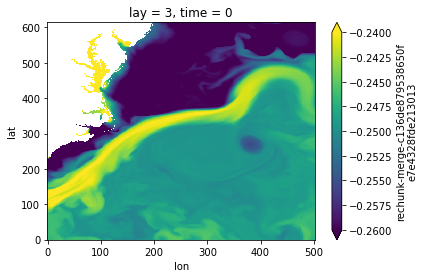

In [10]:
b_win.isel(time=0,lay=3).plot(vmax=-.24, vmin=-.26)

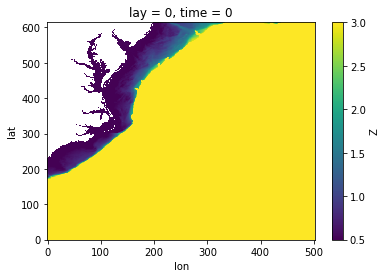

In [27]:
hycom01w.Z.isel(time=0,lay=0).plot()

In [8]:
zs = np.concatenate((np.linspace(3.1,35.97241992,10, endpoint=False), (1+np.tanh(np.linspace(-2,0,40)))*1e3))
zp1s = np.concatenate((np.array([1.55]),.5*(zs[1:] + zs[:-1])))
from scipy.interpolate import interp1d
f = interp1d(np.arange(len(np.diff(zp1s))), np.abs(np.diff(zp1s)), fill_value='extrapolate')
dzp1s = f(np.arange(len(np.diff(zp1s))+1))
dzp1s

array([ 3.193621  ,  3.28724199,  3.28724199,  3.28724199,  3.28724199,
        3.28724199,  3.28724199,  3.28724199,  3.28724199,  3.28724199,
        3.54764146,  4.00508682,  4.41857019,  4.87252431,  5.37042207,
        5.91592588,  6.51287229,  7.1652487 ,  7.87716075,  8.65278859,
        9.49632995, 10.41192823, 11.40358345, 12.47504419, 13.62967876,
       14.8703244 , 16.19911391, 17.61728007, 19.12493942, 20.72085899,
       22.40221107, 24.16432403, 26.00043946, 27.90148896, 29.85590644,
       31.84949421, 33.86536253, 35.8839629 , 37.88323384, 39.83887484,
       41.72475863, 43.51348399, 45.17706184, 46.68771554, 48.01876536,
       49.1455555 , 50.04637364, 50.70330799, 51.10298599, 51.50266399])

In [9]:
sw = grid.transform(hycom01w.s3.chunk({'lay':-1}), 
                    'Z', zs, 
                    target_data=hycom01w.Z.chunk({'lay':-1})
                   ).transpose('time','Z','lat','lon')
mask = ~np.ma.masked_invalid(sw).mask

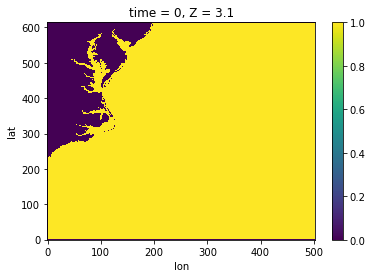

In [10]:
wet_mask = xr.DataArray(np.zeros((len(hycom01w.time),len(zs),len(hycom01w.lat),len(hycom01w.lon))),
                        dims=['time','Z','lat','lon'],
                        coords={'time':hycom01w.time,'Z':zs,
                                'lat':hycom01w.lat,'lon':hycom01w.lon}
           )
wet_mask[...,1:-1,1:-1] = mask[...,1:-1,1:-1].astype(np.float64)
wet_mask = wet_mask.chunk({'time':10,'Z':10,'lat':100,'lon':100})
wet_mask.isel(time=0,Z=0).plot()

In [ ]:
l10 = 2    # grid index of ~10m depth
MLDw = xr.ones_like(sig0w.isel(lay=0)).load()

for i in range(len(hycom01w.time)):
    nMLDw = np.abs((sig0w.isel(time=i,lay=slice(l10,None)).fillna(0.)
                    - sig0w.isel(time=i,lay=l10).fillna(0.)
                   ) - .03).reset_coords(drop=True).argmin(dim='lay',skipna=True).compute()  # indexing needs loading
    MLDw[i] = hycom01w.Z.where(hycom01w.Z>0.).isel(time=i)[{'lay':nMLDw}].chunk({'lat':200,'lon':200})
    if i == 0:
        MLDw.isel(time=0).plot()
        plt.show()
    print(i)


In [18]:
tmp_path = f'{SCRATCH}/region01/HYCOM50/'+f'MLD_fma.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
MLDw.reset_coords(drop=True).chunk({'time':10}).to_dataset(name='MLD').to_zarr(store_tmp, mode='w')

gcs://meom-ige-scratch/roxyboy/region01/HYCOM50/MLD_fma.zarr


In [108]:
nMLDs = z10 + np.abs((sig0s.isel(depth=slice(z10,None)).fillna(0.)
                      - sig0s.isel(depth=z10).fillna(0.)
                     ) - .03).reset_coords(drop=True).argmin(dim='depth').compute()  # indexing needs loading
MLDs = (xr.ones_like(sig0s) 
        * fesom01w.depth).reset_coords(drop=True)[{'depth':nMLDs}]  
# del nMLDs
MLDs

<xarray.DataArray (time_counter: 89, y: 763, x: 611)>
dask.array<reshape, shape=(89, 763, 611), dtype=float64, chunksize=(89, 763, 611), chunktype=numpy.ndarray>
Coordinates:
    deptht        (time_counter, y, x) float64 115.2 109.0 103.1 ... 70.72 70.72
  * time_counter  (time_counter) datetime64[ns] 2010-02-01 ... 2010-04-30
Dimensions without coordinates: y, x

In [139]:
tmp_path = f'{SCRATCH}/region01/HYCOM50/'+f'MLD_aso.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
MLDs.reset_coords(drop=True).chunk({'y':200,'x':160}).to_dataset(name='MLD').to_zarr(store_tmp, mode='w')

gcs://meom-ige-scratch/roxyboy/region01/eNATL60/MLD_aso.zarr


In [11]:
MLDw = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/HYCOM50/MLD_fma.zarr")
                   ).MLD.chunk({'time':10,'lat':100,'lon':100})

MLDw

<xarray.DataArray 'MLD' (time: 90, lat: 615, lon: 503)>
dask.array<rechunk-merge, shape=(90, 615, 503), dtype=float64, chunksize=(10, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
Dimensions without coordinates: lat, lon

In [12]:
area = (hycom01w.dxF * hycom01w.dyF)

area

<xarray.DataArray (lat: 615, lon: 503)>
array([[3708108.99095141, 3708108.99095141, 3710939.60849388, ...,
        3710939.60849388, 3708108.99095141, 3708108.99095141],
       [3706645.47994286, 3706645.47994286, 3709474.98030135, ...,
        3709474.98030135, 3706645.47994286, 3706645.47994286],
       [3705386.13262003, 3705386.13262003, 3708214.67164467, ...,
        3708214.67164467, 3705386.13262003, 3705386.13262003],
       ...,
       [2901209.98145378, 2901209.98145378, 2903424.64555193, ...,
        2903424.64555193, 2901209.98145378, 2901209.98145378],
       [2900198.08624643, 2900198.08624643, 2902411.97790548, ...,
        2902411.97790548, 2900198.08624643, 2900198.08624643],
       [2899547.14515209, 2899547.14515209, 2901760.53990954, ...,
        2901760.53990954, 2899547.14515209, 2899547.14515209]])
Coordinates:
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 495 496 497 498 499 500 501 502
  * lat      (lat) int64 0 1 2 3 4 5 6 7 8 ... 607 608 609 610 611 612 613 614

In [13]:
dxw = xr.DataArray(hycom01w.dxC.data,
                   dims=area.dims, coords=area.coords
                  ) # x-spacing centered at western cell edge

dyw = xr.DataArray(hycom01w.dyG.data,
                   dims=area.dims, coords=area.coords
                  ) # y-spacing centered at western cell edge

dxs = xr.DataArray(hycom01w.dxG.data,
                   dims=area.dims, coords=area.coords
                  ) # x-spacing centered at southern cell edge

dys = xr.DataArray(hycom01w.dyC.data,
                   dims=area.dims, coords=area.coords
                  ) # y-spacing centered at southern cell edge
dxw

<xarray.DataArray (lat: 615, lon: 503)>
array([[1925.11172042, 1925.11172042, 1925.11172042, ..., 1928.05082228,
        1925.11172042, 1925.11172042],
       [1924.77578622, 1924.77578622, 1924.77578622, ..., 1927.71437519,
        1924.77578622, 1924.77578622],
       [1924.43975016, 1924.43975016, 1924.43975016, ..., 1927.3778261 ,
        1924.43975016, 1924.43975016],
       ...,
       [1702.88900321, 1702.88900321, 1702.88900321, ..., 1705.48883374,
        1702.88900321, 1702.88900321],
       [1702.50700215, 1702.50700215, 1702.50700215, ..., 1705.10624947,
        1702.50700215, 1702.50700215],
       [1702.12487936, 1702.12487936, 1702.12487936, ..., 1704.72354329,
        1702.12487936, 1702.12487936]])
Coordinates:
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 495 496 497 498 499 500 501 502
  * lat      (lat) int64 0 1 2 3 4 5 6 7 8 ... 607 608 609 610 611 612 613 614

In [14]:
dx_min = min(dxw.min(), dyw.min(), dxs.min(), dys.min())
dx_min = dx_min.values
dx_min

array(1702.12487936)

In [15]:
kappa_w = xr.ones_like(wet_mask.isel(time=0))

kappa_s = xr.ones_like(wet_mask.isel(time=0))
kappa_s

<xarray.DataArray (Z: 50, lat: 615, lon: 503)>
dask.array<full, shape=(50, 615, 503), dtype=float64, chunksize=(10, 100, 100), chunktype=numpy.ndarray>
Coordinates:
    time     int64 0
  * Z        (Z) float64 3.1 6.387 9.674 12.96 16.25 ... 847.4 897.8 948.8 1e+03
  * lat      (lat) int64 0 1 2 3 4 5 6 7 8 ... 607 608 609 610 611 612 613 614
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 495 496 497 498 499 500 501 502

In [16]:
bw = grid.transform(b_win.chunk({'lay':-1}), 
                    'Z', zs, 
                    target_data=hycom01w.Z.chunk({'lay':-1})
                   ).transpose('time','Z','lat','lon').compute().chunk({'time':10,'Z':10,'lat':100,'lon':100})
ww = grid.transform(grid.interp(hycom01w.w3,'Z',boundary='extend').chunk({'lay':-1}), 
                    'Z', zs, 
                    target_data=hycom01w.Z.chunk({'lay':-1})
                   ).transpose('time','Z','lat','lon').compute().chunk({'time':10,'Z':10,'lat':100,'lon':100})
ww

,Array,Chunk
Bytes,10.37 GiB,7.63 MiB
Shape,"(90, 50, 615, 503)","(10, 10, 100, 100)"
Count,1890 Tasks,1890 Chunks
Type,float64,numpy.ndarray


In [17]:
filter_scale = 30000.
filt_mask = wet_mask.chunk({'lat':-1,'lon':-1}).reset_coords(drop=True)

filter_30km = gcm_filters.Filter(
        filter_scale=filter_scale,
        dx_min=dx_min,
    #     n_steps=36,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
        grid_vars={
            'wet_mask': filt_mask, 
            'dxw': dxw.chunk({'lat':-1,'lon':-1}), 'dyw': dyw.chunk({'lat':-1,'lon':-1}), 
            'dxs': dxs.chunk({'lat':-1,'lon':-1}), 'dys': dys.chunk({'lat':-1,'lon':-1}), 
            'area': area.chunk({'lat':-1,'lon':-1}), 
            'kappa_w': kappa_w.chunk({'lat':-1,'lon':-1}), 
            'kappa_s': kappa_s.chunk({'lat':-1,'lon':-1})
        }
    )

In [20]:
ww_filtered_to_30km = filter_30km.apply(ww.chunk({'lat':-1,'lon':-1}), dims=['lat','lon'])


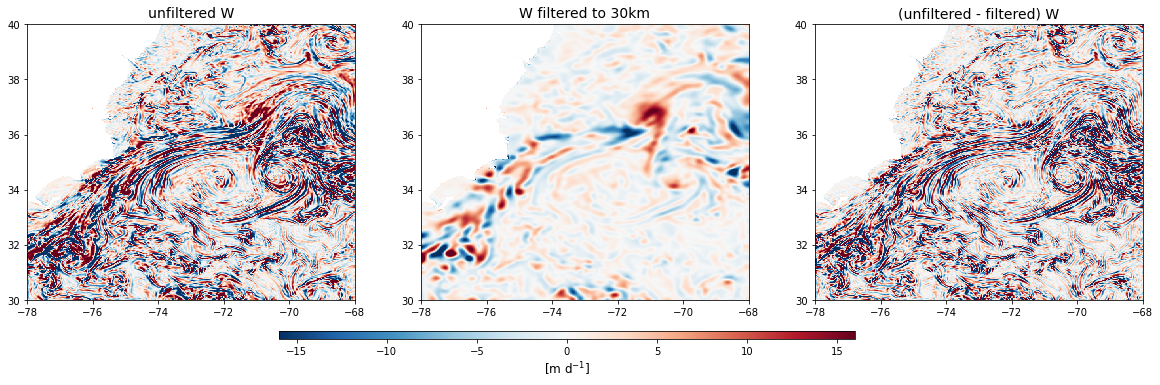

In [45]:
vmin = -16
vmax = 16

fig, axs = plt.subplots(1,3,figsize=(20,6))

im = axs[0].pcolormesh(hycom01w.longitude.isel(lon=slice(1,-1)), 
                       hycom01w.latitude.isel(lat=slice(1,-1)),
                       (ww*86400).isel(time=0, Z=5,
                                       lat=slice(1,-1),lon=slice(1,-1)), 
                       vmin=vmin, vmax=vmax, 
                       cmap='RdBu_r', 
#                   cbar_kwargs={'label': r'm d$^{-1}$'},
                       shading='auto', rasterized=True
)
axs[0].set_title('unfiltered W', fontsize=14)

axs[1].pcolormesh(hycom01w.longitude.isel(lon=slice(1,-1)), 
                  hycom01w.latitude.isel(lat=slice(1,-1)),
                  (ww_filtered_to_30km.isel(time=0,Z=5,
                                            lat=slice(1,-1),lon=slice(1,-1))*86400), 
                vmin=vmin, vmax=vmax, 
                cmap='RdBu_r', 
#                   cbar_kwargs={'label': r'm d$^{-1}$'}
                  shading='auto', rasterized=True
)
axs[1].set_title('W filtered to 30km', fontsize=14)

axs[2].pcolormesh(hycom01w.longitude.isel(lon=slice(1,-1)), 
                  hycom01w.latitude.isel(lat=slice(1,-1)),
                  ((ww.isel(time=0,Z=5) 
                    - ww_filtered_to_30km.isel(time=0,Z=5)
                   )*86400).isel(lat=slice(1,-1),lon=slice(1,-1)), 
                  vmax=vmax, vmin=vmin,
                  cmap='RdBu_r', 
#                   cbar_kwargs={'label': r'm d$^{-1}$'}
                  shading='auto', rasterized=True
)
axs[2].set_title(r'(unfiltered - filtered) W', fontsize=14);

fig.subplots_adjust(bottom=0.24, hspace=.25)
cbaxes = fig.add_axes([0.3, 0.15, 0.4, 0.018]) 
cbar = fig.colorbar(im, orientation='horizontal', cax=cbaxes,
#                     ticks=[-2.8,-2.1,-1.4,-.7,0.,.7,1.4,2.1,2.8]
                   )
# cbar.set_powerlimits(-1,1)
cbar.set_label(r'[m d$^{-1}$]', fontsize=12)

plt.savefig('/home/jovyan/Figures/HYCOM01_wp_Feb-01.pdf')

In [21]:
bw_filtered_to_30km = filter_30km.apply(bw.chunk({'lat':-1,'lon':-1}), dims=['lat','lon'])

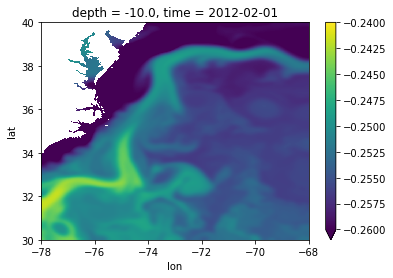

In [34]:
(bw_filtered_to_30km.isel(time=0,depth=2)).plot(vmin=-.26, vmax=-.24)

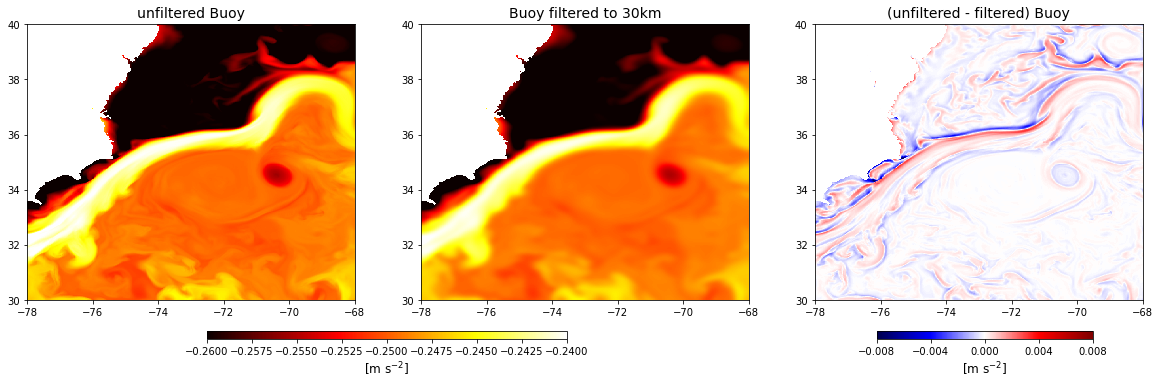

In [47]:
vmin = -.26
vmax = -.24

fig, axs = plt.subplots(1,3,figsize=(20,6))

im = axs[0].pcolormesh(hycom01w.longitude.isel(lon=slice(1,-1)), 
                       hycom01w.latitude.isel(lat=slice(1,-1)),
                       (bw).isel(time=0,Z=5,lat=slice(1,-1),lon=slice(1,-1)), 
                       vmin=vmin, vmax=vmax, 
                       cmap='hot', 
                       shading='auto', rasterized=True
)
axs[0].set_title(r'unfiltered Buoy', fontsize=14)

axs[1].pcolormesh(hycom01w.longitude.isel(lon=slice(1,-1)), 
                  hycom01w.latitude.isel(lat=slice(1,-1)),
                  bw_filtered_to_30km.isel(time=0,Z=5,
                                           lat=slice(1,-1),lon=slice(1,-1)), 
                  vmin=vmin, vmax=vmax, 
                  cmap='hot', 
                  shading='auto', rasterized=True
)
axs[1].set_title(r'Buoy filtered to 30km', fontsize=14)

im2 = axs[2].pcolormesh(hycom01w.longitude.isel(lon=slice(1,-1)), 
                        hycom01w.latitude.isel(lat=slice(1,-1)),
                        (bw.isel(time=0,Z=5) 
                         - bw_filtered_to_30km.isel(time=0,Z=5)
                        ).isel(lat=slice(1,-1),lon=slice(1,-1)), 
                        vmax=.008, vmin=-.008,
                        cmap='seismic', 
                        shading='auto', rasterized=True
)
axs[2].set_title(r'(unfiltered - filtered) Buoy', fontsize=14);

fig.subplots_adjust(bottom=0.24, hspace=.25)
cbaxes = fig.add_axes([0.25, 0.15, 0.25, 0.018]) 
cbar = fig.colorbar(im, orientation='horizontal', cax=cbaxes,
#                     ticks=[-2.8,-2.1,-1.4,-.7,0.,.7,1.4,2.1,2.8]
                   )
# cbar.set_powerlimits(-1,1)
cbar.set_label(r'[m s$^{-2}$]', fontsize=12)
cbaxes = fig.add_axes([0.715, 0.15, 0.15, 0.018]) 
cbar = fig.colorbar(im2, orientation='horizontal', cax=cbaxes,
                    ticks=[-.008,-.004,0.,.004,.008]
                   )
# cbar.set_powerlimits(-1,1)
cbar.set_label(r'[m s$^{-2}$]', fontsize=12)

plt.savefig('/home/jovyan/Figures/HYCOM01_bp_Feb-01.pdf')

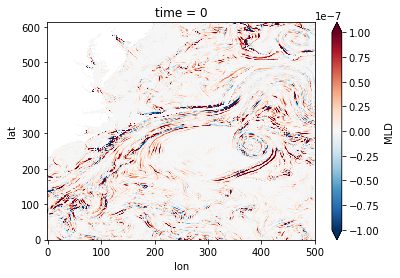

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
gcs://meom-ige-scratch/roxyboy/region01/HYCOM50/wb-30km_z0-MLD_fma.zarr


In [18]:
wpbpw = xr.zeros_like(MLDw.isel(lat=slice(1,-1),lon=slice(1,-1))).load()

filter_scale = 30000.   # 30 km
for i in range(len(hycom01w.time)):
    
    filt_mask = wet_mask.isel(time=i).chunk({'lat':-1,'lon':-1}).reset_coords(drop=True)
    filter_30km = gcm_filters.Filter(
        filter_scale=filter_scale,
        dx_min=dx_min,
    #     n_steps=36,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
        grid_vars={
            'wet_mask': filt_mask, 
            'dxw': dxw.chunk({'lat':-1,'lon':-1}), 'dyw': dyw.chunk({'lat':-1,'lon':-1}), 
            'dxs': dxs.chunk({'lat':-1,'lon':-1}), 'dys': dys.chunk({'lat':-1,'lon':-1}), 
            'area': area.chunk({'lat':-1,'lon':-1}), 
            'kappa_w': kappa_w.chunk({'lat':-1,'lon':-1}), 
            'kappa_s': kappa_s.chunk({'lat':-1,'lon':-1})
        }
    )
    
    ww_filtered_to_30km = filter_30km.apply(ww.isel(time=i).chunk({'lat':-1,'lon':-1}),
                                            dims=['lat','lon']
                                           ).chunk({'lat':100,'lon':100}).isel(lat=slice(1,-1),lon=slice(1,-1))
    bw_filtered_to_30km = filter_30km.apply(bw.isel(time=i).chunk({'lat':-1,'lon':-1}),
                                            dims=['lat','lon']
                                           ).chunk({'lat':100,'lon':100}).isel(lat=slice(1,-1),lon=slice(1,-1))
    
    wpbpw[i] = ((((ww.isel(time=i,lat=slice(1,-1),lon=slice(1,-1)) 
                   - ww_filtered_to_30km)
                  * (bw.isel(time=i,lat=slice(1,-1),lon=slice(1,-1)) 
                     - bw_filtered_to_30km)
                 ).where(wet_mask.isel(time=i,lat=slice(1,-1),lon=slice(1,-1))!=0.)
                 * xr.DataArray(dzp1s, dims=['Z'])
                ).where(ww.Z <= MLDw.isel(time=i,lat=slice(1,-1),lon=slice(1,-1))
                       ).sum('Z',skipna=True) 
                / MLDw.isel(time=i,lat=slice(1,-1),lon=slice(1,-1))
               ).chunk({'lat':100,'lon':100})
    if i == 0:
        wpbpw.isel(time=i).plot(vmax=1e-7)
        plt.show()
    print(i)


tmp_path = f'{SCRATCH}/region01/HYCOM50/'+f'wb-30km_z0-MLD_fma.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
wpbpw.reset_coords(drop=True).chunk({'time':10}).to_dataset(name='wpbp').to_zarr(store_tmp, mode='w')

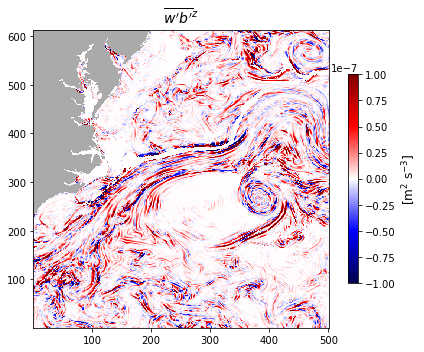

In [20]:
wpbpw = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/HYCOM50/wb-30km_z0-MLD_fma.zarr")).wpbp

fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)
im = ax.pcolormesh(hycom01w.lon.isel(lon=slice(1,-1)), 
                   hycom01w.lat.isel(lat=slice(1,-1)),
                   wpbpw.isel(time=0).where(wet_mask.isel(time=0,Z=0,lat=slice(1,-1),lon=slice(1,-1))!=0.),
                   vmin=-1e-7, vmax=1e-7,
                   cmap='seismic', shading='auto', rasterized=True
)
ax.pcolormesh(hycom01w.lon.isel(lon=slice(1,-1)), 
              hycom01w.lat.isel(lat=slice(1,-1)),
              np.ma.masked_invalid(wet_mask.where(wet_mask!=1).isel(time=0,Z=0,lat=slice(1,-1),lon=slice(1,-1))),
              vmin=-1, vmax=2,
              cmap='binary', shading='auto', rasterized=True)

ax.set_title(r"$\overline{w'b'}^z$", fontsize=14)
cbar = fig.colorbar(im, ax=ax, shrink=.7)
cbar.set_label(r"[m$^2$ s$^{-3}$]", fontsize=12)

plt.savefig('/home/jovyan/Figures/HYCOM01_wpbpz_Feb-01.pdf')